# Add Cycle-Level Features
We use a few different types of faetures that summarize cycles for the machine learning models.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from batdata.postprocess.integral import CapacityPerCycle, StateOfCharge
from batdata.postprocess.cycle_stats import CycleTimes
from batdata.data import BatteryDataset
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from pathlib import Path
from tqdm import tqdm
import pandas as pd

Configuration

In [2]:
hdf5_path = './data/hdf5/'

## Load in an example cell
Start with one to show off how this works

In [3]:
dataset = BatteryDataset.from_batdata_hdf('./data/hdf5/refined/batch_B28B_cell_2.h5')

## Compute the Features
Each is described using a different class

### Capacity Per Cycle
Compute the amount of charge pushed into the battery and the 

In [4]:
CapacityPerCycle().add_summaries(dataset)

Text(0, 0.5, 'Charge Capacity (A-hr)')

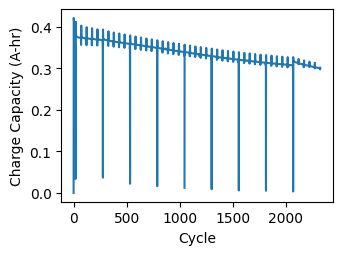

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(dataset.cycle_stats['capacity_charge'])

ax.set_xlabel('Cycle')
ax.set_ylabel('Charge Capacity (A-hr)')

In [6]:
dataset.cycle_stats.head(5)

,cycle_number,energy_charge,capacity_charge,energy_discharge,capacity_discharge
0,0,0.000000,0.000000,4.336126e-07,1.250629e-07
1,1,1.545621,0.420994,1.460777e+00,3.913739e-01
2,2,1.539038,0.419249,1.562767e+00,4.219581e-01
3,3,1.517108,0.413389,1.555165e+00,4.194255e-01
4,4,1.513609,0.412468,1.534272e+00,4.134041e-01


## Run for each cell
Load in, create cycle summaries, save back

In [7]:
feature_computers = [CapacityPerCycle(), StateOfCharge(), CycleTimes()]

Make a function we can run in parallel

In [8]:
def add_features(file: Path, computers: list):
    """Add features to a certain file"""
    from warnings import catch_warnings, filterwarnings
    dataset = BatteryDataset.from_batdata_hdf(str(file))
    with catch_warnings():
        filterwarnings('ignore')
        for feature in feature_computers:
            feature.compute_features(dataset)
    dataset.to_batdata_hdf(str(file), complevel=9)
    return file
func = partial(add_features, computers=feature_computers)

In [9]:
for path in tqdm(Path(hdf5_path).rglob('*.h5')):
    func(path)

602it [10:50,  1.08s/it]


## Show the improved HDF5 file
The features are now part of HDF5 file

In [10]:
dataset = BatteryDataset.from_batdata_hdf('./data/hdf5/refined/batch_B28B_cell_2.h5')

In [11]:
dataset.cycle_stats.head(5)

,cycle_number,energy_charge,capacity_charge,energy_discharge,capacity_discharge,cycle_start,cycle_duration
0,0,0.000000,0.000000,4.336126e-07,1.250629e-07,0.000,60.048
1,1,1.545621,0.420994,1.460777e+00,3.913739e-01,60.048,156219.450
2,2,1.539038,0.419249,1.562767e+00,4.219581e-01,156279.498,161755.470
3,3,1.517108,0.413389,1.555165e+00,4.194255e-01,318034.968,80239.932
4,4,1.513609,0.412468,1.534272e+00,4.134041e-01,398274.900,79615.722
